## A solução foi implementada no google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importação dos principais pacotes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import os
import os,glob
from keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from os import listdir,makedirs
from os.path import isfile,join
from pathlib import Path

# Scaneando todos os arquivos jpg da pasta images

In [3]:
def scan_files(path,regra): 
    resultados = list(Path(path).rglob(str(regra)))
    return resultados

In [4]:
filenames = scan_files(path = '/content/drive/MyDrive/archive/images/images',regra = "*.[jJ][pP][gG]") #existem 3 arquivos com extensão diferente de .jpg, então iremos ignora-los

# Uma vez que a cor não é importante para diferenciar se é cachorro ou gato, iremos utilizar imagens em escala de cinza a fim de reduzir a complexidade e podendo utilizar-se de resoluções maiores

## Cria a pasta destino das imagens cinzas

In [5]:
path = '/content/drive/MyDrive/archive/images/images' # Source Folder
dstpath = '/content/drive/MyDrive/archive/images/gray_images' # Destination Folder
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

## Converte para escala de cinza

In [6]:
# Folder won't used
files = filenames
altura_total = 0
largura_total = 0
count = 0
for count, image in enumerate(files):
    try:
        original_image = image
        image = str(image)
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        dstPath = join(dstpath,original_image.name)
        cv2.imwrite(dstPath,gray)
        altura,largura,ch = img.shape
        altura_total = altura_total +  altura
        largura_total = largura_total + largura
    except:
        pass
        print ("{} is not converted".format(image))

altura_media = int(altura_total/(count+1)) #390
largura_media = int(largura_total/(count+1)) #436
print('Fim da conversão')

/content/drive/MyDrive/archive/images/images/Egyptian_Mau_139.jpg is not converted
/content/drive/MyDrive/archive/images/images/Egyptian_Mau_145.jpg is not converted
/content/drive/MyDrive/archive/images/images/Egyptian_Mau_167.jpg is not converted
/content/drive/MyDrive/archive/images/images/Egyptian_Mau_177.jpg is not converted
/content/drive/MyDrive/archive/images/images/Egyptian_Mau_191.jpg is not converted
/content/drive/MyDrive/archive/images/images/Abyssinian_34.jpg is not converted
Fim da conversão


# A fim de não gerar muitas distorções nas imagens, iremos utilizar a resolução média das imagens

In [7]:
altura_media,largura_media

(390, 436)

In [8]:
#Propriedades das imagens
Image_Width=largura_media
Image_Height=altura_media
Image_Size=(Image_Width,Image_Height)
Image_Channels= 1

# Scaneando o caminho das imagens em escala de cinza

In [9]:
filenames = scan_files(path = '/content/drive/MyDrive/archive/images/gray_images',regra = "*.[jJ][pP][gG]") #existem 3 arquivos com extensão diferente de .jpg, então iremos ignora-los

# Criando os rótulos

In [10]:
cats = 0
dogs = 0
#Preparando o dataset para o treinamento do modelo:
categories=[]
for f_name in filenames:
    file_name = f_name.name
    file_name = str(file_name)[:str(file_name).find('.')]

    if file_name.istitle():
        categories.append(0) # cat = 0
        cats +=1
    else:
        categories.append(1) # dog = 1
        dogs+=1

In [11]:
cats,dogs

(2394, 4990)

In [12]:
cats+dogs

7384

In [13]:
str_filenames = []
for f_name in filenames:
    str_filename = '/content/drive/MyDrive/archive/images/gray_images/'+f_name.name
    str_filenames.append(str_filename)

# Criando a estrutura da rede

In [14]:
#Criando o modelo de rede neural:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D, Dropout,Flatten,Dense,Activation, BatchNormalization
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [15]:
# Analisando as camadas do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 434, 388, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 434, 388, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 217, 194, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 217, 194, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 215, 192, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 215, 192, 64)     2

In [16]:
#Definindo os callbacks e o LR

from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

earlystop = EarlyStopping(patience = 20)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_model_gray.h5', monitor= 'val_accuracy', save_best_only=True) 

callbacks = [earlystop,learning_rate_reduction,checkpoint]

## Stratificando pela categoria com menor casos. Nesse caso, a categoria gatos que possuem menos amostras

In [17]:
df=pd.DataFrame({
    'filename':str_filenames,
    'category':categories
})
df = df.groupby('category', group_keys=False).apply(lambda x: x.sample(min(len(x), min(cats,dogs)))).reset_index(drop=True)

# Splitando entre o conjunto de treino e validação

In [18]:
#Splitando e ajustando os dfs
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20, random_state=42,shuffle=True) #, stratify = df['category']
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size= 15

In [19]:
#Gerando a base de treino
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1/255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "/content/drive/MyDrive/archive/images/gray_images/",
                                                 x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size, 
                                                 color_mode='grayscale',
                                                 shuffle=True)

Found 3830 validated image filenames belonging to 2 classes.


In [20]:
# Gerando a base de validação
validation_datagen = ImageDataGenerator(rescale=1/255) # 1.255
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/archive/images/gray_images/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size, 
    color_mode='grayscale',
    shuffle=True)

Found 958 validated image filenames belonging to 2 classes.


# Treinamento do modelo

In [21]:
# Treinamento do modelo
epochs=50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks,
    verbose = 1
)

Epoch 1/50
255/255 [==============================] - 140s 505ms/step - loss: 1.1480 - accuracy: 0.5578 - val_loss: 0.9726 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 2/50
255/255 [==============================] - 108s 409ms/step - loss: 0.7628 - accuracy: 0.6118 - val_loss: 0.7139 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 3/50
255/255 [==============================] - 112s 436ms/step - loss: 0.6838 - accuracy: 0.6320 - val_loss: 0.6139 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 4/50
255/255 [==============================] - 107s 402ms/step - loss: 0.6483 - accuracy: 0.6537 - val_loss: 0.6250 - val_accuracy: 0.6582 - lr: 0.0010
Epoch 5/50
255/255 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.6684
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
255/255 [==============================] - 95s 373ms/step - loss: 0.6290 - accuracy: 0.6684 - val_loss: 1.1484 - val_accuracy: 0.6063 - lr: 0.0010
Epoch 6/50
255/255 [=====================

In [22]:
model.save('/content/drive/MyDrive/last_model_gray.h5')

In [23]:
from tensorflow import keras
#model = keras.models.load_model('/content/drive/MyDrive/last_model_gray.h5')
#model = keras.models.load_model('/content/drive/MyDrive/best_model_gray.h5')

In [24]:
evaluation = model.evaluate(
    train_generator,
    verbose=1,
    max_queue_size=10,
    workers=2,
    use_multiprocessing=True,
)

256/256 [==============================] - 57s 222ms/step - loss: 0.4054 - accuracy: 0.8151


In [25]:
print(f'Test Loss: {evaluation[0]} | Test accurracy: {evaluation[1]}')

Test Loss: 0.4053851366043091 | Test accurracy: 0.8151435852050781


# Matriz de confusão

In [26]:
# Matriz de confusão da base de validação
predict = model.predict_generator(validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [27]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [28]:
previsoes = np.argmax(predict, axis=-1)

In [29]:
cm = confusion_matrix(y_true=validate_df['category'].replace({ 'dog': 1, 'cat': 0 }), y_pred=previsoes)

In [30]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
cm_plot_labels = ['Cat','Dog']

Confusion matrix, without normalization
[[242 232]
 [229 255]]


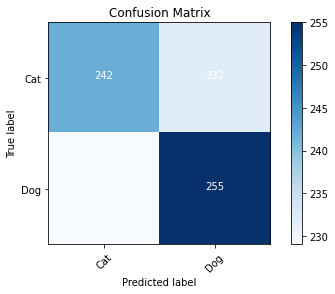

In [32]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')